<a href="https://colab.research.google.com/github/sanchitvj/AOD-net-using-TF-v2/blob/master/dehazing_using_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanchitvj","key":"408457caf2f2e83829ad732b5c1c2ddd"}'}

In [5]:
!mkdir .kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists


In [6]:
!kaggle datasets list -s dehaze

ref                  title     size  lastUpdated          downloadCount  
-------------------  --------  ----  -------------------  -------------  
wwwwwee/dehaze       dehaze     2GB  2020-03-09 03:17:46             34  
rahulbhalley/dehaze  dehaze     2GB  2020-04-29 17:55:31              2  
wwwwwee/infrared     infrared   2GB  2020-04-26 12:23:04              5  


In [7]:
!kaggle datasets download -d wwwwwee/dehaze

100% 1.78G/1.78G [01:12<00:00, 21.3MB/s]
100% 1.78G/1.78G [01:12<00:00, 26.4MB/s]


In [8]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: haze/0698_0.85_0.2.jpg  
  inflating: haze/0698_0.8_0.04.jpg  
  inflating: haze/0698_0.8_0.06.jpg  
  inflating: haze/0698_0.8_0.08.jpg  
  inflating: haze/0698_0.8_0.1.jpg   
  inflating: haze/0698_0.8_0.12.jpg  
  inflating: haze/0698_0.8_0.16.jpg  
  inflating: haze/0698_0.8_0.2.jpg   
  inflating: haze/0698_0.95_0.04.jpg  
  inflating: haze/0698_0.95_0.06.jpg  
  inflating: haze/0698_0.95_0.08.jpg  
  inflating: haze/0698_0.95_0.1.jpg  
  inflating: haze/0698_0.95_0.12.jpg  
  inflating: haze/0698_0.95_0.16.jpg  
  inflating: haze/0698_0.95_0.2.jpg  
  inflating: haze/0698_0.9_0.04.jpg  
  inflating: haze/0698_0.9_0.06.jpg  
  inflating: haze/0698_0.9_0.08.jpg  
  inflating: haze/0698_0.9_0.1.jpg   
  inflating: haze/0698_0.9_0.12.jpg  
  inflating: haze/0698_0.9_0.16.jpg  
  inflating: haze/0698_0.9_0.2.jpg   
  inflating: haze/0698_1_0.04.jpg    
  inflating: haze/0698_1_0.06.jpg    
  inflating: haze/0698_1_0.08.jp

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
#from kaggle_datasets import KaggleDataset

In [10]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (550, 413), antialias = True)
    img = img / 255.0
    return img

In [11]:
def data_path(orig_img_path, hazy_img_path):
    
    train_img = []
    val_img = []
    
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    n = len(orig_img)
    random.shuffle(orig_img)
    train_keys = orig_img[:int(0.9*n)]
    val_keys = orig_img[int(0.9*n):]
    
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
        
    hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    for img in hazy_img:
        img_name = img.split('/')[-1]
        orig_path = orig_img_path + '/' + img_name.split('_')[0] + '.jpg'
        if (split_dict[orig_path] == 'train'):
            train_img.append([img, orig_path])
        else:
            val_img.append([img, orig_path])
            
    return train_img, val_img

In [12]:
def dataloader(train_data, val_data, batch_size):
    
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(100).batch(batch_size)
    
    return train, val

In [13]:
def dehaze_net():
    
    inputs = tf.keras.Input(shape = [550,413,3])
    conv1 = Conv2D(input_shape = (550, 413, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(inputs)
    conv2 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(conv1)
    concat1 = tf.concat([conv1,conv2], axis = -1)
    
    conv3 = Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat1)
    concat2 = tf.concat([conv2,conv3], axis = -1)
    
    conv4 = Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4], axis = -1)
    
    conv5 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat3)
    K = conv5
    output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
    
    #model = Model(inputs = x, outputs = output)
    
    return Model(inputs = inputs, outputs = output)

In [14]:
epochs = 10
batch_size = 64

train_data, val_data = data_path(orig_img_path = '/content/clear_images', hazy_img_path = '/content/haze')
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net = dehaze_net()

train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

In [15]:
def display_img(model, hazy_img, orig_img):
    pred = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], pred[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

In [17]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()

        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                loss = mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 8 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            if step % 64 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [========================]  -  Training Loss: 0.2504

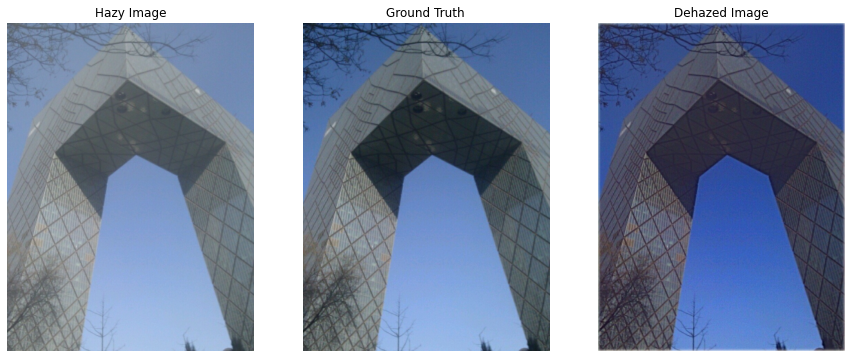

  -  Validation Loss: 0.0148  -   Time taken: 663.76s

Start of epoch 1 [========================]  -  Training Loss: 0.0133

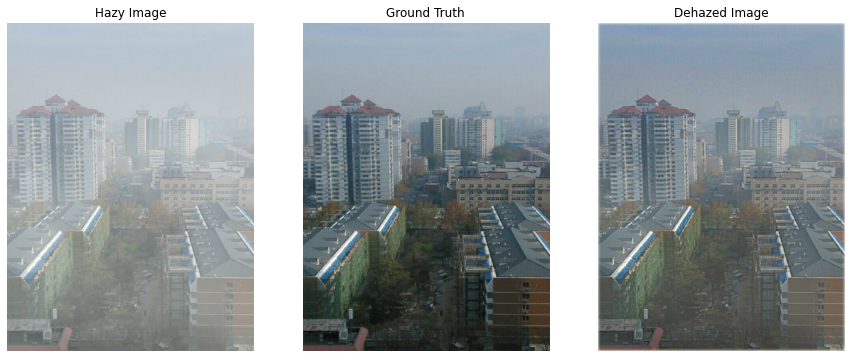

  -  Validation Loss: 0.0128  -   Time taken: 647.06s

Start of epoch 2 [========================]  -  Training Loss: 0.0117

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


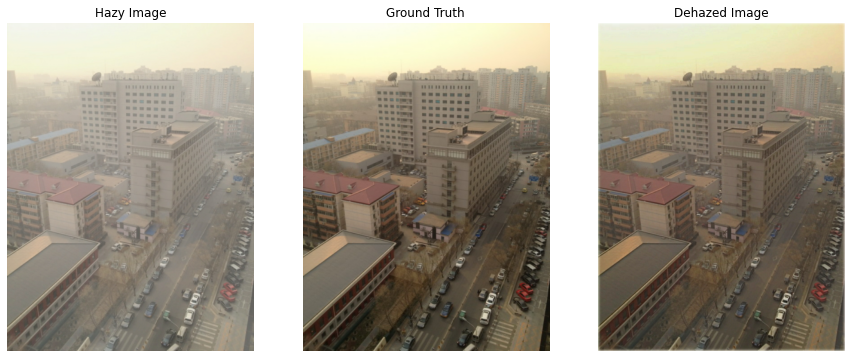

  -  Validation Loss: 0.0116  -   Time taken: 635.56s

Start of epoch 3 [========================]  -  Training Loss: 0.0106

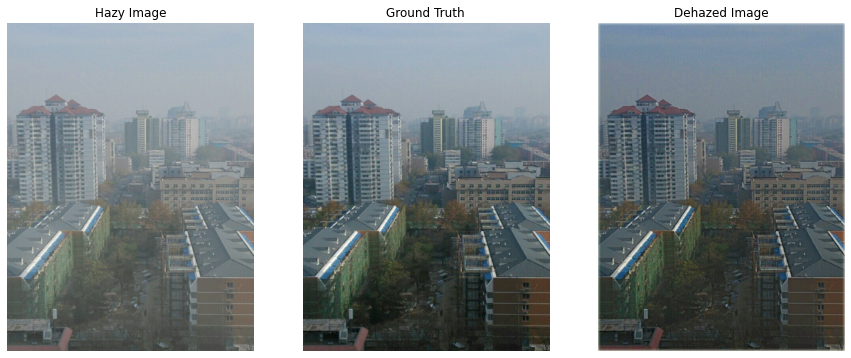

  -  Validation Loss: 0.0108  -   Time taken: 635.12s

Start of epoch 4 [========================]  -  Training Loss: 0.0100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


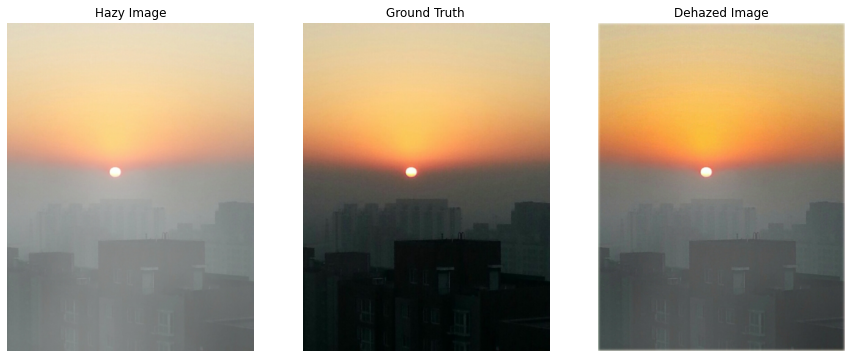

  -  Validation Loss: 0.0104  -   Time taken: 633.92s

Start of epoch 5 [========================]  -  Training Loss: 0.0096

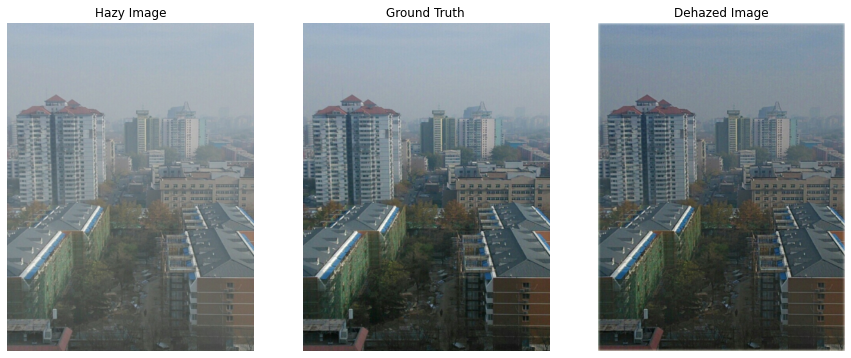

  -  Validation Loss: 0.0102  -   Time taken: 633.02s

Start of epoch 6 [========================]  -  Training Loss: 0.0094

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


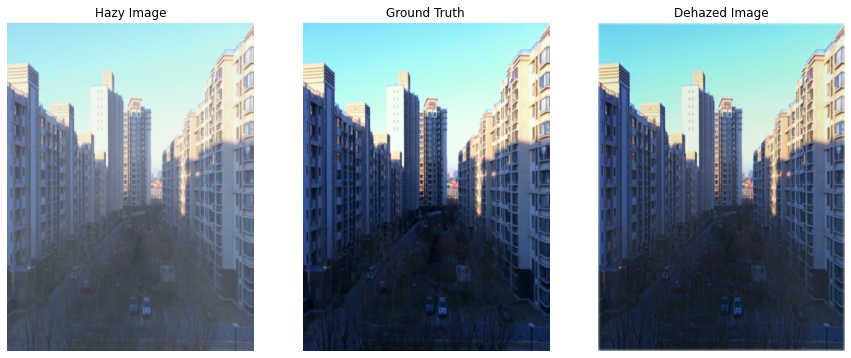

  -  Validation Loss: 0.0101  -   Time taken: 631.29s

Start of epoch 7 [========================]  -  Training Loss: 0.0094

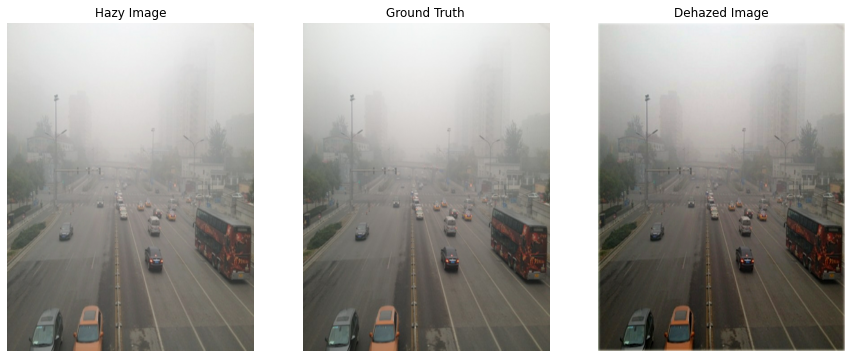

  -  Validation Loss: 0.0100  -   Time taken: 630.49s

Start of epoch 8 [========================]  -  Training Loss: 0.0093

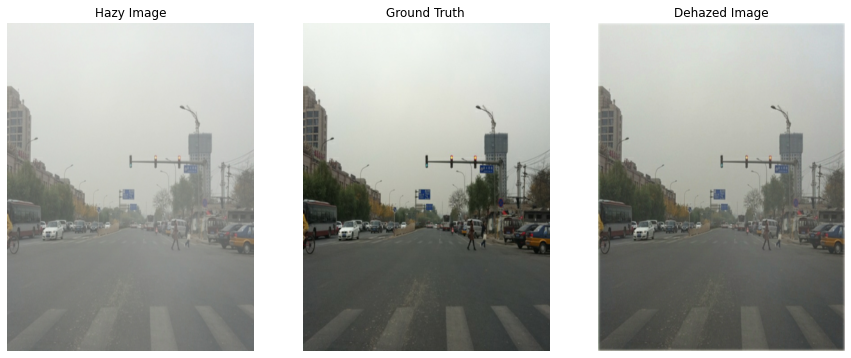

  -  Validation Loss: 0.0100  -   Time taken: 622.77s

Start of epoch 9 [========================]  -  Training Loss: 0.0093

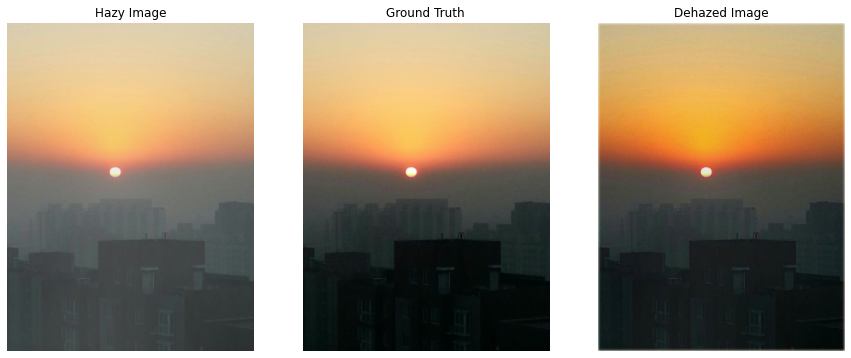

  -  Validation Loss: 0.0099  -   Time taken: 620.93s
CPU times: user 1h 3min 51s, sys: 9min 22s, total: 1h 13min 13s
Wall time: 1h 45min 53s


In [18]:
%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)